In [1]:
print ("Python is easy!")

Python is easy!


In [2]:
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import statistics
import cv2
import os
import scipy.signal as ss
import skimage
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)


debug = 1

In [3]:
def showimage(image, name='image_'):
    if (debug==1):
        cv2.namedWindow(name)
        cv2.imshow(name, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cv2.imwrite(name+'.jpg', image)
    return

In [38]:
def PreProcessImage(image):

    ## TODO searchwindow size based on image size
    ## Step 0 Non local means denoising
    image = cv2.fastNlMeansDenoisingColored(image,None,h=7,hColor=7,templateWindowSize=7,searchWindowSize=35)
    showimage(image, 'nlmeans-0')
    
       
    ##canonical1 Contours 502, good rects 490, compound rects 12, discarded rects 0, chars 427, dropped chars 3
    ##           Contours 504, good rects 493, compound rects 11, discarded rects 0, chars 428, dropped chars 3
    
    ##canonical2 Contours 668, good rects 664, compound rects 4, discarded rects 0, chars 562, dropped chars 6
    ##           Contours 625, good rects 623, compound rects 2, discarded rects 0, chars 556, dropped chars 5
    ##           Contours 786, good rects 784, compound rects 1, discarded rects 1, chars 571, dropped chars 1
    ##           Contours 661, good rects 659, compound rects 2, discarded rects 0, chars 567, dropped chars 3
    
    ##canonical3 Contours 471, good rects 463, compound rects 8, discarded rects 0, chars 406, dropped chars 2
    ##           Contours 474, good rects 466, compound rects 8, discarded rects 0, chars 406, dropped chars 2
    
    ##devnagri/style1 Contours 655, good rects 653, compound rects 0, discarded rects 2, chars 499, dropped chars 1
    ##                Contours 733, good rects 733, compound rects 0, discarded rects 0, chars 515, dropped chars 0
    ##                Contours 671, good rects 671, compound rects 0, discarded rects 0, chars 503, dropped chars 1
    ##                Contours 669, good rects 667, compound rects 0, discarded rects 2, chars 504, dropped chars 1
    
    ##tough1 Contours 721, good rects 682, compound rects 34, discarded rects 5, chars 449, dropped chars 22
    ##       Contours 729, good rects 696, compound rects 32, discarded rects 1, chars 514, dropped chars 22
    ##       Contours 687, good rects 648, compound rects 35, discarded rects 4, chars 466, dropped chars 27
    ##       Contours 670, good rects 638, compound rects 30, discarded rects 2, chars 511, dropped chars 23
    ##       Contours 721, good rects 689, compound rects 30, discarded rects 2, chars 513, dropped chars 22
    ##       Contours 721, good rects 689, compound rects 30, discarded rects 2, chars 513, dropped chars 22
    ##       Contours 667, good rects 629, compound rects 36, discarded rects 2, chars 450, dropped chars 45
    ##       Contours 667, good rects 629, compound rects 36, discarded rects 2, chars 454, dropped chars 36
    
    
    ##1238 Contours 793, good rects 788, compound rects 3, discarded rects 2, chars 631, dropped chars 8
    
    ##1239 Contours 858, good rects 853, compound rects 5, discarded rects 0, chars 658, dropped chars 21
    
    ##1240 Contours 826, good rects 816, compound rects 8, discarded rects 2, chars 663, dropped chars 11

    ## Step 1 bilateral with conservative params, but multiple times
    for i in range(100):
        image = cv2.bilateralFilter(image,2,10,10)
    showimage(image, 'bilateral-1')
    
    ## Step 2 median blur with conservative params
    image = cv2.medianBlur(image,3)
    showimage(image,'medianblurred-2')
    
    ## Step 3 convert to grey scale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    showimage(image, 'grayimage-3')
   
    return image

def ThresholdWithOTSU(image):
    thirdH = int(image.shape[0]/3)
    thirdW = int(image.shape[1]/3)
    roi = image[thirdH:2*thirdH, thirdW:2*thirdW] 
    
    histr = cv2.calcHist([image],[0],None,[256],[0,256]) 
    plt.plot(histr)
    plt.show()

    histr = cv2.calcHist([roi],[0],None,[256],[0,256]) 
    plt.plot(histr)
    plt.show()
          
    img2 = image.copy()
    ot, roit = cv2.threshold(roi, 0, 255, cv2.THRESH_OTSU)    
    _, ti = cv2.threshold(img2, ot, 255, cv2.THRESH_BINARY_INV)
    showimage(ti, 'raw-otsu')
    contours, _ = cv2.findContours(ti,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    mask = np.ones(image.shape[:2], dtype="uint8") * 255
    
    mask_remove = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    mask_retain = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
 
    # loop over the contours
    for c in contours:
        # if the contour is bad, draw it on the mask
        if is_good_contour_for_line_segmentation(c, ti)==True:
            r = cv2.boundingRect(c)
            cv2.rectangle(mask, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), color=0, thickness=-1)
            cv2.drawContours(mask_retain, [c], 0, color=(0,255,0), thickness=1)
        else:
            #r = cv2.boundingRect(c)
            cv2.drawContours(mask_remove, [c], 0, color=(0,0,255), thickness=-1)
    
    showimage(mask_retain, 'retaining-this')
    showimage(mask_remove, 'removing-this')

    # remove the contours from the image and show the resulting images
    showimage(255-mask,'contour-removal-mask')
    ## AARGH! someone please simplify this! X is the correct form, it has already been inverted so text is white.
    x = cv2.bitwise_and(ti,ti, mask=255-mask)
    return x
    
def is_good_contour_for_line_segmentation(c, image):
    ## boundingRect is x,y,w,h. Note w>4h and 5px limit is a postprocessing condition too. 
    ## minRect is ( center (x,y), (width, height), angle of rotation ) w=r[1][0], h=r[1][1]
    mask = np.zeros(image.shape,np.uint8)
    cv2.drawContours(mask,[c],0,255,-1)
    avg_intensity = cv2.mean(image, mask=mask)
    
    ## TODO this removes straight lines like "1" in 1049
    r = cv2.minAreaRect(c)
    if (r[1][0]<=5 or r[1][1]<=5 or (r[1][0]<=10 and r[1][0]>4*r[1][1])):
        #print('reporting bad contour rect, intensity', r, avg_intensity)
        return False
    
    ## remove large contours only if intensity is high i.e. no risk of text within
    if (r[1][1]>img.shape[0]/2 or r[1][0]>img.shape[1]/2):
        print('reporting large contour', r, avg_intensity)
        if (avg_intensity[0]>250): # grayscale only first component is populated
            print('reporting large bad contour rect', r, avg_intensity)
            return False
    
    return True

def ThresholdSauvola(img):
    ## based on observation using these values of k,r work best (default k=0.2)
    thresh_sauvola = threshold_sauvola(img.copy(), window_size=31, k=0.1, r=45)
    binary_sauvola = img > thresh_sauvola
    image = binary_sauvola.astype('uint8')*255

    ## Sauvola is edge sensitive and prone to creating thick borders around image. Try remove them based on size
    contours, _ = cv2.findContours(255-image.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    mask = np.ones(img.shape[:2], dtype="uint8") * 255
 
    mask_remove = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    mask_retain = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
 
    # loop over the contours
    for c in contours:
        # if the contour is bad, draw it on the mask
        if is_good_contour_for_line_segmentation(c, 255-image.copy())==True:
            r = cv2.boundingRect(c)
            cv2.rectangle(mask, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), color=0, thickness=-1)
            cv2.drawContours(mask_retain, [c], 0, color=(0,255,0), thickness=1)
        else:
            #r = cv2.boundingRect(c)
            cv2.drawContours(mask_remove, [c], 0, color=(0,0,255), thickness=-1)
    
    showimage(mask_retain, 'retaining-this')
    showimage(mask_remove, 'removing-this')


    # remove the contours from the image and show the resulting images
    showimage(255-mask,'contour-removal-mask')
    ## AARGH! someone please simplify this! X is the correct form, it has already been inverted so text is white.
    x = cv2.bitwise_and(255-image.copy(),255-mask, mask=255-mask)
    return x

## Analyse intensity histogram of gray scale image. Ideally it should be bimodal. Examine the top two peaks, if we
## have narrow well separated peaks that indicates good contrast. A broad peak that spans many intensity values
## indicates spread and low contrast
def IsLowContrast(image):
    hist = cv2.calcHist([image],[0],None,[256],[0,256]) 
    hist = hist/img.size
    
    x = np.reshape(hist, len(hist))
    window_size = 21
    hist_s = ss.savgol_filter(x, window_size, 5) 
    maxval = np.max(hist_s)
    peaks, info = ss.find_peaks(hist_s, prominence=maxval/10, width=5)
    widths = np.sort(info['widths'])
    
    ## !!width is sensitive to window size. If window size is too high the graph will have wide curves and 
    ## bad approximation
    ## with current params width of good peaks seems to be about 10-20 range and spread peaks > 30.
    ## we expect bimodal distribution. Check if top two widths exceed 30
    if (len(widths)>=2):
        if (widths[-1]>30 or widths[-2]>30):
            return True
    
    return False

def getlinewidth(lp):
    ## multiple ways to calculate avg line width. Can take median of h values. Or if variance is high,
    ## can take diff of line positions in that vicinity which will be more accurate?
    lpdiff = np.diff(lp)
    return int(np.sum(lpdiff)/len(lpdiff))

def findpeaks(image, dist, horizontal_profile=True):
    if (horizontal_profile):
        intensity_hist = cv2.reduce(image, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    else:
        intensity_hist = cv2.reduce(image, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S).T
    
    ## smoothen the intensity histogram using savgol to avoid noise
    x = np.reshape(intensity_hist, len(intensity_hist))
    window_size = 5
    if (horizontal_profile):
        window_size = int(image.shape[0]/22)  ## magic num!
    else:
        window_size = int(image.shape[1]/22)  ## magic num!
    if (window_size%2 == 0):
        window_size = window_size+1
    intensity_hist_s = ss.savgol_filter(x, window_size, 5) 
    intensity_hist_s = intensity_hist_s.astype(int)

    ## find peaks in smooth plot. Prominence is via observation - if a line has just
    ## a few letters it will create a small peak. We enforce roughly 1/10 of the line
    ## should be occupied with letters
    ## distance is to avoid quirks. We use 5 degree poly to smoothen so it leads to dual
    ## peaks at times close together. Distance specification is a heuristic to avoid
    ## getting too close peaks. Ideally we should skip that, but use this routine recursively
    ## by plugging in the median of linewidths back into the find_peaks as distance till
    ## convergence
    maxval = np.max(intensity_hist_s)
    peaks, _ = ss.find_peaks(intensity_hist_s, prominence=maxval/10, distance=dist)
    return intensity_hist, peaks, intensity_hist_s
       

def DoStraightLines(image):
    
    ## by default, specify distance of 10 pixels to avoid peaks that are too close
    intensity_hist, peaks, intensity_hist_s = findpeaks(image, 10)
    
    
    """
    plt.figure(figsize=(10,5))
    plt.xticks(range(0, img.shape[0], int(img.shape[0]/10))) 
    plt.xlim([0, img.shape[0]])
    plt.plot(intensity_hist)
    plt.plot(peaks, intensity_hist[peaks], "x")
    plt.show()
    """
    
    ## peaks is a simple list [y1 y2 y3...yn] where n=number of lines. Convert to contour from x=lm to rm
    contours = []
    for i, y in enumerate(peaks):
        contour = []
        for x in range(lm, rm, 1):
            contour.append([x,y])
        
        ## convert list to array  
        contour = np.array(contour).reshape((-1,1,2)).astype(np.int32)
        contours.append(contour)
        
    lw = getlinewidth(peaks)
    print('peaks {0}, linewidth {1}'.format(peaks, lw))
    return peaks, lw, contours

def FindMargins(img):
    intensity_hist = cv2.reduce(img, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S).T
    ## smoothen the intensity histogram using savgol to avoid noise
    x = np.reshape(intensity_hist, len(intensity_hist))
    window_size = int(img.shape[1]/22)  ## magic num!
    if (window_size%2 == 0):
        window_size = window_size+1
    intensity_hist_s = ss.savgol_filter(x, window_size, 5) 
    intensity_hist_s = intensity_hist_s.astype(int)

    ## TODO reexamine prominence here - not same as for horizontal lines can be a stricter bound
    maxval = np.max(intensity_hist_s)
    peaks, _ = ss.find_peaks(intensity_hist_s, prominence=maxval/10, distance=10)
    
    """
    plt.figure(figsize=(10,5))
    plt.xticks(range(0, img.shape[1], int(img.shape[1]/10))) 
    plt.xlim([0, img.shape[1]])
    plt.plot(intensity_hist)
    plt.plot(intensity_hist_s, color='green')
    plt.plot(peaks, intensity_hist[peaks], "x")
    plt.show()
    """
    
    data = ss.peak_widths(intensity_hist_s, peaks, rel_height=1)
    #print('peak width data', data)
    widest_peak_index = np.argmax(data[0])
    #print('widest peak index', widest_peak_index)
    left_index = data[2][widest_peak_index]
    right_index = data[3][widest_peak_index]
    return int(left_index), int(right_index)


## smudge image from left to right to do more precise line determination
def DoHorizontalSmudge(image):
    for i in range(1,100,1):
        image = cv2.GaussianBlur(image,(5,5),sigmaX=1,sigmaY=0.01)
    return image


## This runs through vertical moving window of image from left margin to right margin, accumulating intensity profile 
## information - #peaks and linewidth of each slice. Returns back median of #peaks and average linewidth, std dev linewidth
def EstimateLines(image, min_peak_distance):
    
    line_slices = [] 
    window = 300
    lw_sizes = []
    peak_sizes = []

    ## debug output    
    imgLines = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    
    for i in range(lm+1,rm):
        roi = image[:,max(lm,i-window):i]   
        intensity_hist, peaks, intensity_hist_s = findpeaks(roi, min_peak_distance)
        
        """if (i%500 == 0):
            plt.figure(figsize=(10,5))
            plt.xticks(range(0, image.shape[0], int(image.shape[0]/10))) 
            plt.xlim([0, image.shape[0]])

            plt.plot(intensity_hist)
            plt.plot(peaks, intensity_hist[peaks], "x")
            plt.show()
        """

        ## start recording vertical slice peaks, later used for threading
        peak_sizes.append(len(peaks))
        if (len(peaks)>1):
            lw = getlinewidth(peaks)
            lw_sizes.append(lw)
        else:
            print('### no peaks! y=', i)
        line_slices.append(peaks)
        
        for _, p in enumerate(peaks):
            ## draw a broad band 9px wide
            imgLines[p-4,i] = [255,0,0]
            imgLines[p-3,i] = [255,0,0]
            imgLines[p-2,i] = [255,0,0]
            imgLines[p-1,i] = [255,0,0]
            imgLines[p,i] = [255,0,0]
            imgLines[p+1,i] = [255,0,0]
            imgLines[p+2,i] = [255,0,0]
            imgLines[p+3,i] = [255,0,0]
            imgLines[p+4,i] = [255,0,0] 
        
    showimage(imgLines,'lines-with-smudge')
    return np.max(peak_sizes), np.median(peak_sizes), np.mean(lw_sizes), np.std(lw_sizes), np.min(lw_sizes), line_slices

## Given there exist maximum num_straight_lines, draw them across the whole image also in areas where there are no
## letters
def CreateMissingLines(curr_slice, prev_slice, horizontal_index, debug=0):
    if (debug == 1):
        print('previou peaks {0}'.format(prev_slice))
        print('current peaks {0}'.format(curr_slice))
            
    updated_slice = np.zeros(num_straight_lines, dtype='uint')

    ## iterate current slice and find each index is closest to which index of right slice and map them.
    for i, c in enumerate(curr_slice):
        d = 1000000 # some very high number
        best_match_index = -1
        for j, p in enumerate(prev_slice):
            if (abs(c-p)<d):
                d = abs(c-p)
                ## current best match for i in curr slice is j in right slice
                best_match_index = j
        if (debug==1):
            print('index {0} of curr is closest to index {1} of prev'.format(i, best_match_index))
        if (updated_slice[best_match_index] == 0):   
            updated_slice[best_match_index] = c
        else:
            ## TODO need better algo here?
            print('oops found two lines mapping to previous line, skipping index {0} for y={1}'.format(best_match_index, c))

    ## after all indexes in current slice are mapped to closest index in previous slice fill holes
    for i, y in enumerate(updated_slice):
        if (y==0):
            ## for first index no option but pick from neighbor, all others can utilize local linewidth
            if (i==0):
                updated_slice[i] = prev_slice[i]
            else:
                updated_slice[i] = updated_slice[i-1] + prev_slice[i] - prev_slice[i-1] 

    return updated_slice
    
    
## thread together line positions in each vertical slice. If a slice has less than num_straight_line peaks, extrapolate
## from neighboring slices
def CreateLineContours(line_data):
    ## there are rm-lm slices. Lines (i,j) records for column i, horizontal position j the y position of the intensity peak
    lines = np.zeros((rm-lm,num_straight_lines), dtype="uint")
    ## going from left to right, find the first slice that has num_straight_lines peaks
    horizontal_index = 0
    horizontal_index_back = 0
    for i,p in enumerate(line_data):
        if (len(p) != num_straight_lines):
            continue
        print('starting threading at {0} relative to left margin {1}'.format(lm+i))
        horizontal_index = i
        horizontal_index_back = i-1
        break
    
    while (horizontal_index_back >= 0):
        #print('working on index {0} relative to lm'.format(horizontal_index_back))
        curr_slice = line_data[horizontal_index_back]
        prev_slice = line_data[horizontal_index_back+1]
        updated_slice = CreateMissingLines(curr_slice, prev_slice, horizontal_index_back)
           
        line_data[horizontal_index_back] = updated_slice
        lines[horizontal_index_back] = updated_slice
        #print('updated slice for index {0} - {1}'.format(horizontal_index_back, updated_slice))
            
        horizontal_index_back = horizontal_index_back-1
    
    while (horizontal_index < len(line_data)):
        #print('working on index {0}'.format(horizontal_index+lm))
        curr_slice = line_data[horizontal_index]
        prev_slice = line_data[horizontal_index-1]
        updated_slice = CreateMissingLines(curr_slice, prev_slice, horizontal_index)
        
        line_data[horizontal_index] = updated_slice
        lines[horizontal_index] = updated_slice
        #print('updated slice for index {0} - {1}'.format(horizontal_index+lm, updated_slice))
            
        horizontal_index = horizontal_index+1
        
    ## at this point the lines 2D array is ready for horizontal threading. Visualize it
    ## there is an indexing bug where lines has a last row of all 0. Trim it
    lines = lines[:lines.shape[0]-1, :]
    horizontal_lines = lines.T
    
    ## contours is a list of np array
    contours = []
    for i, line in enumerate(horizontal_lines):
        n = len(line)
        contour = np.zeros((n,1,2), dtype="int")
        ## contour points are in (x,y) format!
        for x, z in enumerate(line):
            contour[x] = np.array([[x+lm,z]])
    
        contours.append(contour)
        
    return contours       

In [59]:
cwd = os.getcwd()
print('cwd', cwd)
os.chdir('..\..\Devnagri\Style1')
print('now', os.getcwd())

cwd C:\Users\darshat\Desktop\ImageWork\Devnagri\Tilted
now C:\Users\darshat\Desktop\ImageWork\Devnagri\Style1


In [60]:
img = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
print("Image size and shape ", img.size, img.shape)
## Shape=(y,x)

## Steps 0-4 are preprocessing - nlmeans denoising, bilateral, medianblur, gray scale
image = PreProcessImage(img)


Image size and shape  32905188 (4161, 2636, 3)


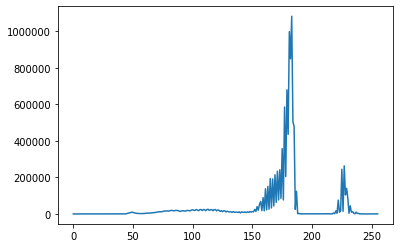

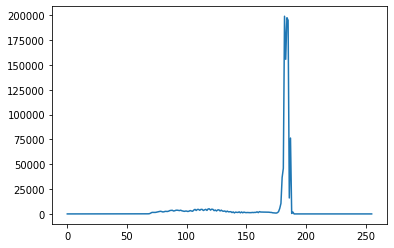

reporting large contour ((2539.16455078125, 2077.0126953125), (4002.0068359375, 27.331893920898438), -89.92835235595703) (255.0, 0.0, 0.0, 0.0)
reporting large bad contour rect ((2539.16455078125, 2077.0126953125), (4002.0068359375, 27.331893920898438), -89.92835235595703) (255.0, 0.0, 0.0, 0.0)
reporting large contour ((83.76171112060547, 2076.0185546875), (4002.061767578125, 22.450483322143555), -89.75434112548828) (255.0, 0.0, 0.0, 0.0)
reporting large bad contour rect ((83.76171112060547, 2076.0185546875), (4002.061767578125, 22.450483322143555), -89.75434112548828) (255.0, 0.0, 0.0, 0.0)


In [61]:
img = image
if (IsLowContrast(img)):
    img = ThresholdSauvola(img)
    showimage(img, 'sauvola-4')
else:
    img = ThresholdWithOTSU(img)
    showimage(img, 'otsu-4')

In [62]:
## find approx left and right margins.
lm, rm = FindMargins(img)
print('left and right margins', lm, rm)

## find approx linewidth assuming straight lines. This does not account for skew but creates baseline for more precise algo
## later
peakpositions, linewidth, straight_line_contours = DoStraightLines(img) 
num_straight_lines = len(peakpositions)

print('#straightlines, linewidth estimate', num_straight_lines, linewidth)

left and right margins 308 2290
peaks [ 150  364  505  624  733  845  974 1078 1194 1302 1406 1518 1637 1768
 1891 2004 2118 2232 2351 2529 2647 2767 2884 2991 3102 3214 3338 3452
 3562 3670 3798], linewidth 121
#straightlines, linewidth estimate 31 121


In [63]:
## Try to account for line skew. If all goes well then line_contours has accurage peak info else peakpositions has peak info
img2 = DoHorizontalSmudge(img.copy())
showimage(img2, 'horizontal-smudge-45')

## get intensity profile of moving window starting from left margin
min_peak_distance = int(0.75*linewidth)
num_lines, num_lines_median, mean_linewidth, min_linewidth, std_linewidth, line_data = EstimateLines(img2.copy(), min_peak_distance)
print('Approx1: #maxlines={0}, mean linewidth={1}, min linewidth={2}, stddev linewidth={3}, #medianlines={4}'.format(num_lines, mean_linewidth, min_linewidth, std_linewidth, num_lines_median))

### no peaks! y= 309
### no peaks! y= 310
### no peaks! y= 311
### no peaks! y= 312
### no peaks! y= 313
### no peaks! y= 314
### no peaks! y= 315
### no peaks! y= 316
### no peaks! y= 317
### no peaks! y= 318
### no peaks! y= 319
Approx1: #maxlines=33, mean linewidth=119.90659898477158, min linewidth=12.758411462732527, stddev linewidth=91, #medianlines=30.0


In [64]:
line_contours = []

#lines should not differ much from straight line estimate - if it does fall back to using straight lines!
if (abs(num_lines-num_straight_lines)<=5):
    num_straight_lines=int(num_lines)
    line_contours = CreateLineContours(line_data) 
    
else:
    print('Using straight line algo!')
    line_contours = straight_line_contours

img3 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
cv2.polylines(img3, line_contours, False, (255,0,0))
showimage(img3,'line-contours')

#np.savetxt("linepositions.csv", line_contours, delimiter=",")

starting threading at 971 relative to left margin 308
oops found two lines mapping to previous line, skipping index 29 for y=3488
working on index 1453
previou peaks [  19  134  258  362  508  609  726  844  970 1078 1198 1305 1415 1529
 1641 1763 1884 2005 2126 2249 2357 2530 2644 2765 2885 2992 3102 3211
 3336 3445 3559 3667 3805]
current peaks [  19  134  258  361  508  609  726  844  970 1078 1198 1305 1415 1529
 1641 1763 1884 2005 2126 2249 2357 2530 2644 2765 2885 2992 3102 3211
 3336 3445 3559 3667 3805]
index 0 of curr is closest to index 0 of prev
index 1 of curr is closest to index 1 of prev
index 2 of curr is closest to index 2 of prev
index 3 of curr is closest to index 3 of prev
index 4 of curr is closest to index 4 of prev
index 5 of curr is closest to index 5 of prev
index 6 of curr is closest to index 6 of prev
index 7 of curr is closest to index 7 of prev
index 8 of curr is closest to index 8 of prev
index 9 of curr is closest to index 9 of prev
index 10 of curr is cl

index 8 of curr is closest to index 8 of prev
index 9 of curr is closest to index 9 of prev
index 10 of curr is closest to index 10 of prev
index 11 of curr is closest to index 11 of prev
index 12 of curr is closest to index 12 of prev
index 13 of curr is closest to index 13 of prev
index 14 of curr is closest to index 14 of prev
index 15 of curr is closest to index 15 of prev
index 16 of curr is closest to index 16 of prev
index 17 of curr is closest to index 17 of prev
index 18 of curr is closest to index 18 of prev
index 19 of curr is closest to index 19 of prev
index 20 of curr is closest to index 20 of prev
index 21 of curr is closest to index 21 of prev
index 22 of curr is closest to index 22 of prev
index 23 of curr is closest to index 23 of prev
index 24 of curr is closest to index 24 of prev
index 25 of curr is closest to index 25 of prev
index 26 of curr is closest to index 26 of prev
index 27 of curr is closest to index 27 of prev
index 28 of curr is closest to index 28 of p

index 13 of curr is closest to index 13 of prev
index 14 of curr is closest to index 14 of prev
index 15 of curr is closest to index 15 of prev
index 16 of curr is closest to index 16 of prev
index 17 of curr is closest to index 17 of prev
index 18 of curr is closest to index 18 of prev
index 19 of curr is closest to index 19 of prev
index 20 of curr is closest to index 20 of prev
index 21 of curr is closest to index 21 of prev
index 22 of curr is closest to index 22 of prev
index 23 of curr is closest to index 23 of prev
index 24 of curr is closest to index 24 of prev
index 25 of curr is closest to index 25 of prev
index 26 of curr is closest to index 26 of prev
index 27 of curr is closest to index 27 of prev
index 28 of curr is closest to index 28 of prev
index 29 of curr is closest to index 29 of prev
index 30 of curr is closest to index 30 of prev
index 31 of curr is closest to index 31 of prev
index 32 of curr is closest to index 32 of prev
updated slice for index 1511 - [  19  13

index 16 of curr is closest to index 17 of prev
index 17 of curr is closest to index 18 of prev
index 18 of curr is closest to index 19 of prev
index 19 of curr is closest to index 20 of prev
index 20 of curr is closest to index 21 of prev
index 21 of curr is closest to index 22 of prev
index 22 of curr is closest to index 23 of prev
index 23 of curr is closest to index 24 of prev
index 24 of curr is closest to index 25 of prev
index 25 of curr is closest to index 26 of prev
index 26 of curr is closest to index 27 of prev
index 27 of curr is closest to index 28 of prev
index 28 of curr is closest to index 29 of prev
index 29 of curr is closest to index 30 of prev
index 30 of curr is closest to index 31 of prev
index 31 of curr is closest to index 32 of prev
updated slice for index 1540 - [  19  132  254  358  507  623  727  846  970 1084 1197 1304 1414 1515
 1636 1763 1884 2010 2125 2239 2352 2529 2646 2779 2886 2996 3102 3213
 3336 3445 3558 3667 3802]
working on index 1541
previou pe

 3336 3446 3559 3667 3800]
current peaks [ 130  358  506  623  728  846  971 1085 1196 1303 1413 1513 1634 1761
 1885 2011 2124 2238 2351 2528 2651 2779 2886 2996 3102 3213 3336 3446
 3559 3667 3800]
index 0 of curr is closest to index 1 of prev
index 1 of curr is closest to index 3 of prev
index 2 of curr is closest to index 4 of prev
index 3 of curr is closest to index 5 of prev
index 4 of curr is closest to index 6 of prev
index 5 of curr is closest to index 7 of prev
index 6 of curr is closest to index 8 of prev
index 7 of curr is closest to index 9 of prev
index 8 of curr is closest to index 10 of prev
index 9 of curr is closest to index 11 of prev
index 10 of curr is closest to index 12 of prev
index 11 of curr is closest to index 13 of prev
index 12 of curr is closest to index 14 of prev
index 13 of curr is closest to index 15 of prev
index 14 of curr is closest to index 16 of prev
index 15 of curr is closest to index 17 of prev
index 16 of curr is closest to index 18 of prev
in

 3336 3445 3559 3666 3799]
working on index 1590
previou peaks [  18  127  249  358  506  622  728  846  972 1086 1195 1302 1412 1513
 1631 1755 1885 2011 2120 2236 2350 2528 2657 2779 2886 2996 3102 3214
 3336 3445 3559 3666 3799]
current peaks [ 127  358  506  622  727  846  972 1086 1195 1302 1412 1513 1631 1755
 1885 2011 2120 2236 2350 2528 2657 2779 2886 2995 3102 3214 3336 3445
 3559 3666 3799]
index 0 of curr is closest to index 1 of prev
index 1 of curr is closest to index 3 of prev
index 2 of curr is closest to index 4 of prev
index 3 of curr is closest to index 5 of prev
index 4 of curr is closest to index 6 of prev
index 5 of curr is closest to index 7 of prev
index 6 of curr is closest to index 8 of prev
index 7 of curr is closest to index 9 of prev
index 8 of curr is closest to index 10 of prev
index 9 of curr is closest to index 11 of prev
index 10 of curr is closest to index 12 of prev
index 11 of curr is closest to index 13 of prev
index 12 of curr is closest to index 

index 9 of curr is closest to index 11 of prev
index 10 of curr is closest to index 12 of prev
index 11 of curr is closest to index 13 of prev
index 12 of curr is closest to index 14 of prev
index 13 of curr is closest to index 15 of prev
index 14 of curr is closest to index 16 of prev
index 15 of curr is closest to index 17 of prev
index 16 of curr is closest to index 18 of prev
index 17 of curr is closest to index 19 of prev
index 18 of curr is closest to index 20 of prev
index 19 of curr is closest to index 21 of prev
index 20 of curr is closest to index 22 of prev
index 21 of curr is closest to index 23 of prev
index 22 of curr is closest to index 24 of prev
index 23 of curr is closest to index 25 of prev
index 24 of curr is closest to index 26 of prev
index 25 of curr is closest to index 27 of prev
index 26 of curr is closest to index 28 of prev
index 27 of curr is closest to index 29 of prev
index 28 of curr is closest to index 30 of prev
index 29 of curr is closest to index 31 o

index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1639 - [  18  124  246  358  507  622  726  844  975 1086 1194 1302 1409 1513
 1631 1755 1883 1998 2121 2234 2348 2528 2654 2781 2885 2994 3101 3215
 3336 3439 3560 3666 3799]
working on index 1640
previou peaks [  18  124  246  358  507  622  726  844  975 1086 1194 1302 1409 1513
 1631 1755 1883 1998 2121 2234 2348 2528 2654 2781 2885 2994 3101 3215
 3336 3439 3560 3666 3799]
current peaks [ 358  507  622  726  844  975 1086 1194 1302 1409 1513 1631 1755 1883
 1998 2121 2234 2348 2528 2654 2781 2885 2994 3101 3215 3336 3439 3560
 3666 3

index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1664 - [  18  124  246  357  507  621  726  843  975 1087 1194 1301 1408 1511
 1631 1754 1882 1997 2120 2232 2347 2527 2657 2781 2885 2994 3101 3215
 3337 3439 3559 3665 3799]
working on index 1665
previou peaks [  18  124  246  357  507  621  726  843  97

index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 2

index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 o

index 29 of curr is closest to index 32 of prev
updated slice for index 1740 - [  18  124  246  360  507  622  730  839  976 1086 1192 1300 1406 1511
 1628 1758 1892 1998 2119 2231 2346 2528 2655 2782 2885 2994 3113 3217
 3337 3440 3560 3666 3794]
working on index 1741
previou peaks [  18  124  246  360  507  622  730  839  976 1086 1192 1300 1406 1511
 1628 1758 1892 1998 2119 2231 2346 2528 2655 2782 2885 2994 3113 3217
 3337 3440 3560 3666 3794]
current peaks [ 360  507  622  730  839  976 1086 1192 1300 1406 1511 1628 1758 1892
 1998 2119 2231 2346 2528 2655 2782 2885 2994 3113 3217 3337 3440 3560
 3666 3794]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of

index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1767 - [  18  124  246  362  507  621  731  838  976 1085 1192 1300 1405 1511
 1628 1759 1892 1997 2119 2231 2345 2528 2655 2782 2885 2995 3113 3217
 3337 3440 3561 3667 3796]
working on index 1768
previou peaks [  18  124  246  362  507  621  731  838  976 1085 1192 1300 1405 1511
 1628 1759 1892 1997 2119 2231 2345 2528 2655 2782 2885 2995 3113 3217
 3337 3440 3561 3667 3796]
current peaks [ 363  507  621  731  838  976 1085 1191 1300 1405 1510 1628 1759 1892
 1997 2119 2231 2345 2528 2655 2782 2885 2995 3113 3217 3337 3440 3561
 3667 3796]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index

index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of pr

index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1817 - [  18  124  246  364  506  621  734  838  975 1084 1190 1299 1403 1508
 1629 1759 1880 1995 2117 2231 2342 2529 2666 2783 2885 2995 3112 3218
 3338 3440 3561 3666 3796]
working on index 1818
previou peaks [  18  124  246  364  506  621  734  838  97

index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1846 - [  18  124  246  364  505  621  735  838  975 1081 1189 1299 1403 1508
 1631 1759 1880 1994 2117 2230 2341 2531 2666 2782 2885 2996 3112 3220
 3339 3441 3561 3666 3797]
working on index 1847
previou peaks [  18  124  246  364  505  621  735  838  975 1081 1189 1299 1403 1508
 1631 1759 1880 1994 2117 2230 2341 2531 2666 2782 2885 2996 3112 3220
 3339 3441 3561 3666 3797]
current peaks [ 364  505  621  735  838  975 1081 1189 1299 1403 1508 1631 1759 1880
 1994 2117 2230 2341 2531 2666

 3666 3798]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of pr

index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1897 - [  18  124  246  364  504  621  735  839  973 1075 1187 1299 1402 1507
 1632 1772 1879 1996 2116 2230 2340 2534 2655 2771 2887 2998 3112 3220
 3341 3442 3561 3666 3799]
working on index 1898
previou peaks [  18  124  246  364  504  621  735  839  973 1075 1187 1299 1402 1507
 1632 1772 1879 1996 2116 2230 2340 2534 2655 2771 2887 2998 3112 3220
 3341 3442 3561 3666 3799]
current peaks [ 364  504  621  735  839  973 1075 1187 1299 1402 1507 1632 1772 1879
 1997 2116 2230 2340 2534 2655 2771 2888 2998 3112 3220 3341 3442 3561
 3666 3799]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 o

index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
ind

index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev

index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1964 - [  18  124  246  366  503  621  735  842  958 1072 1188 1298 1402 1506
 1628 1771 1876 2004 2115 2230 233

index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 1994 - [  18  124  246  366  503  622  735  845  958 1073 1187 1298 1402 1506
 1626 1771 1875 2003 2114 2230 2338 2536 2655 2772 2892 2998 3110 3218
 3334 3452 3562 3667 3799]
working on index 1995
previou peaks [  18  124  246  366  503  622  735  845  958 1073 1187 1298 1402 1506
 1626 1771 1875 2003 2114 2230 2338 2536 2655 2772 2892 2998 3110 3218
 3334 3452 3562 3667 3799]
current peaks [ 366  503  622  735  845  958 1073 1187 1298 1402 1506 1626 1771 1874
 2003 2114 2230 2338 2537 2655 2772 2892 2998 3110 3218 3333 3452 3562
 3667 3799]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6

index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
updated slice for index 2022 - [  18  124  246  365  503  610  736  853  972 1073 1187 1295 1401 1505
 1625 1771 1871 2003 2114 2230 2338 2537 2655 2773 2893 2998 3109 3218
 3333 3452 3562 3668 3800]
working on index 2023
previou peaks [  18  124  246  365  503  610  736  853  972 1073 1187 1295 1401 1505
 1625 1771 1871 2003 

index 22 of curr is closest to index 24 of prev
index 23 of curr is closest to index 25 of prev
index 24 of curr is closest to index 26 of prev
index 25 of curr is closest to index 27 of prev
index 26 of curr is closest to index 28 of prev
index 27 of curr is closest to index 29 of prev
index 28 of curr is closest to index 30 of prev
index 29 of curr is closest to index 31 of prev
index 30 of curr is closest to index 32 of prev
updated slice for index 2046 - [  18  124  246  363  503  610  736  852  972 1073 1185 1292 1401 1504
 1623 1770 1871 2001 2113 2229 2338 2537 2655 2773 2894 2998 3109 3216
 3330 3453 3562 3669 3800]
working on index 2047
previou peaks [  18  124  246  363  503  610  736  852  972 1073 1185 1292 1401 1504
 1623 1770 1871 2001 2113 2229 2338 2537 2655 2773 2894 2998 3109 3216
 3330 3453 3562 3669 3800]
current peaks [ 363  503  610  736  852  972 1073 1185 1292 1401 1504 1623 1770 1871
 2001 2113 2229 2338 2433 2537 2655 2773 2894 2998 3109 3216 3330 3453
 3562 3

index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 20 of prev
oops found two lines mapping to previous line, skipping index 20 for y=2432
index 19 of curr is closest to index 21 of prev
index 20 of curr is closest to index 22 of prev
index 21 of curr is closest to index 23 of prev
index 22 of curr is closest to index 24 of prev
index 23 of curr is closest to index 25 of prev
index 24 of curr is closest to index 26 of prev
index 25 of curr is closest to index 27 of prev
index 26 of curr is closest to index 28 of prev
index 27 of curr is closest to index 29 of prev
index 28 of curr is closest to index 30 of prev
index 29 of curr is closest to index 31 of prev
index 30 of curr is closest to index 32 of prev
updated slic

 3563 3669 3797]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 20 of prev
oops found two lines mapping to previous line, skipping index 20 for y=2433
index 19 of 

index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 20 of prev
oops found two lines mapping to previous line, skipping index 20 for y=2433
index 19 of curr is closest to index 21 of prev
index 20 of curr is closest to index 22 of prev
index 21 of curr is closest to index 23 of prev
index 22 of curr is closest to index 24 of prev
index 23 of curr is closest to index 25 of prev
index 24 of curr is closest to index 26 of prev
index 25 of curr is closest to index 27 of prev
index 26 of curr is closest to index 28 of prev
index 27 of curr is closest to index 29 of prev
index 28 of curr is closest to index 30 of prev
index 29 of 

index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 20 of prev
oops found two lines mapping to previous line, skipping index 20 for y=2433
index 19 of curr is closest to index 21 of prev
index 20 of curr is closest to index 22 of prev
index 21 of curr is closest to index 23 of prev
index 22 of curr is closest to index 24 of prev
index 23 of curr is closest to index 25 of prev
index 24 of curr is closest to index 26 of prev
index 25 of curr is closest to index 27 of prev
index 26 of curr is closest to index 28 of prev
index 27 of curr is closest to index 29 of prev
index 28 of c

index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 20 of prev
oops found two lines mapping to previous line, skipping index 20 for y=2433
index 19 of curr is closest to index 21 of prev
index 20 of curr is closest

updated slice for index 2202 - [  18  124  246  360  503  609  733  844  973 1072 1177 1287 1400 1502
 1620 1770 1872 1994 2108 2218 2332 2536 2657 2795 2896 2999 3099 3215
 3341 3449 3566 3671 3797]
working on index 2203
previou peaks [  18  124  246  360  503  609  733  844  973 1072 1177 1287 1400 1502
 1620 1770 1872 1994 2108 2218 2332 2536 2657 2795 2896 2999 3099 3215
 3341 3449 3566 3671 3797]
current peaks [ 360  503  609  732  844  973 1072 1177 1287 1400 1502 1620 1770 1872
 1994 2108 2218 2332 2536 2657 2795 2896 2999 3099 3215 3341 3449 3566
 3671 3797 4067]
index 0 of curr is closest to index 3 of prev
index 1 of curr is closest to index 4 of prev
index 2 of curr is closest to index 5 of prev
index 3 of curr is closest to index 6 of prev
index 4 of curr is closest to index 7 of prev
index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 

index 5 of curr is closest to index 8 of prev
index 6 of curr is closest to index 9 of prev
index 7 of curr is closest to index 10 of prev
index 8 of curr is closest to index 11 of prev
index 9 of curr is closest to index 12 of prev
index 10 of curr is closest to index 13 of prev
index 11 of curr is closest to index 14 of prev
index 12 of curr is closest to index 15 of prev
index 13 of curr is closest to index 16 of prev
index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev

index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
index 30 of curr is closest to index 32 of prev
oops found two lines mapping to previous line, skipping index 32 for y=4068
updated slice for index 2254 - [  18  124  246  360  502  606  732  841  973 1073 1176 1283 1388 1501
 1620 1769 1876 1994 2106 2215 2329 2535 2659 2796 2896 2999 3099 3217
 3343 3448 3565 3672 3796]
working on index 2255
previou peaks [  18  124  246  360  502  606  732  841  973 1073 1176 1283 1388 1501
 1620 1769 1876 1994 2106 2215 2329 2535 2659 2796 2896 2999 3099 3217
 3343 3448 3565 3672 3796]
current peaks [ 360  502  606  732  841  973 1073 1176 1283 1388 1501 1620 1769 1876
 1994 2106 2215 2329 2535 2659 2796 2896 2999 3099

index 14 of curr is closest to index 17 of prev
index 15 of curr is closest to index 18 of prev
index 16 of curr is closest to index 19 of prev
index 17 of curr is closest to index 20 of prev
index 18 of curr is closest to index 21 of prev
index 19 of curr is closest to index 22 of prev
index 20 of curr is closest to index 23 of prev
index 21 of curr is closest to index 24 of prev
index 22 of curr is closest to index 25 of prev
index 23 of curr is closest to index 26 of prev
index 24 of curr is closest to index 27 of prev
index 25 of curr is closest to index 28 of prev
index 26 of curr is closest to index 29 of prev
index 27 of curr is closest to index 30 of prev
index 28 of curr is closest to index 31 of prev
index 29 of curr is closest to index 32 of prev
index 30 of curr is closest to index 32 of prev
oops found two lines mapping to previous line, skipping index 32 for y=4068
updated slice for index 2277 - [  18  124  246  359  502  606  732  840  973 1073 1176 1282 1387 1501
 1620 

In [65]:
def GetContours(image):
    img1 = image.copy()
    showimage(img1, 'contour-input')
    contours, _ = cv2.findContours(img1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)    
    return contours

def EmitLinesAndRects(line_contours, cdlist, oi, bi, rectcolor, linecolor):
    for (i, cd) in enumerate(cdlist):
        r = cd[1]
        cv2.rectangle(oi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), rectcolor, 1)
        cv2.rectangle(bi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), rectcolor, 1)
    cv2.polylines(oi, line_contours, False, linecolor)
    cv2.polylines(bi, line_contours, False, linecolor)
    
    
def EmitLinesAndConvexHulls(line_contours, cdlist, oi, bi, hullcolor, linecolor):
    for _,cd in enumerate(cdlist):
        hull = cd[2]
        cv2.drawContours(oi, [hull], 0, hullcolor, 1)
        cv2.drawContours(bi, [hull], 0, hullcolor, 1)
    
    cv2.polylines(oi, line_contours, True, linecolor)
    cv2.polylines(bi, line_contours, True, linecolor)

def ShowBoundingRects(cdlist, oi, title):
    for (j, cd) in enumerate(cdlist):
        r = cd[1]
        cv2.rectangle(oi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), (255,0,255), 1)
    showimage(oi, title)
        
def GetImageForConvexHull(hull):
    # create a blank image of size w,h. br is (x,y,w,h)
    ### absolute coordinates cause an issue with hull rendering.
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask,[hull],-1,(255,255,255),-1)
    mask = cv2.bitwise_and(img, img, mask=mask)
    return mask
    
def BreakMergedCharsViaHull(mask, cd, outputdata):
    # split image approx around mid point where intensity projection is weakest
    hist = cv2.reduce(mask, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    #plt.plot(hist)
    #plt.xlim([0, mask.shape[0]])
    #plt.show()
    
    max_y = np.max(hist)
    (x,y,w,h) = cd[1]
    # some sensible default
    currentmin = max_y
    currentminindex = y + int(h/2)
    
    # first y rows should be empty, hull starts around y'th row
    # look for minima in the 35-65% band in the middle
    #print('checking histogram range y, y+h', y, y+h)
    ## TODO fix indexing of for loop to take range (int(y+0.35h)) etc
    for i in range(y, y+h):
        if (i>0.35*h+y and i<0.65*h+y):
            ## if intensity is below average start tracking
            if (hist[i]<currentmin):
                currentmin = hist[i]
                currentminindex = i
                # print('updating minindex to', i)
    
    # print('x,y,currentminindex,h,w', x,y,currentminindex,h,w)
    
    # now redo contouring in each subpart and report the bounding rectangles.
    mask1 = mask.copy()
    mask2 = mask.copy()
    
    mask1[currentminindex:y+h, x:x+w]=0
    mask2[0:currentminindex, x:x+w]=0
    
    c1,_ = cv2.findContours(mask1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE);
    c2,_ = cv2.findContours(mask2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE);
    for (_, c) in enumerate(c1):
        # compute bounding box of contour
        # print('upper contour', c)
        r = cv2.boundingRect(c)
        h = cv2.convexHull(c)
        m = cv2.moments(c)
        if (m["m00"] != 0):
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])

            outputdata.append((c,r,h,(cx,cy)))
            # print('upper broken rect', r)
    for (_, c) in enumerate(c2):
        # compute bounding box of contour
        # print('lower contour', c)
        r = cv2.boundingRect(c)
        h = cv2.convexHull(c)
        m = cv2.moments(c)
        if (m["m00"] != 0):
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])

            outputdata.append((c,r,h,(cx,cy)))
            # print('lower broken rect', r)
    

def PreProcessBoundingRects1(contourdata, linewidth):
    # contourdata has contour, rect, hull, centroid
    cdlist = contourdata.copy()
    simplecontourdata = []
    compoundcontourdata = []
    discardedcontourdata = []
    
    for (i, cd) in enumerate(cdlist):
        rect = cd[1]
        #h is rect[3]
        if (rect[3]/linewidth < 1.2):
            simplecontourdata.append(cd)
        elif (rect[3] <= 2.4*linewidth):
            compoundcontourdata.append(cd)
        else:
            print('discarding large contour', cd)
            discardedcontourdata.append(cd)
            
    s = len(simplecontourdata)
    c = len(compoundcontourdata)
    d = len(discardedcontourdata)
    print('# simple rects', s)
    print('# compound rects', c)
    print('# discarded large rects', d)
    
    oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    ShowBoundingRects(compoundcontourdata, oi, 'compound-bounding-rects')
    
    
    outputdata = []
    
    for (_, cd) in enumerate(compoundcontourdata):
        # Hull break method
        hull = cd[2]
        mask = GetImageForConvexHull(hull)
        # showimage(mask)
        BreakMergedCharsViaHull(mask, cd, outputdata)
        #print('broken rects len', len(output))
        
    oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    ShowBoundingRects(outputdata, oi, 'compound-rects-broken')
    
    for (_, cd) in enumerate(outputdata):
        simplecontourdata.append(cd)
    return simplecontourdata, s, c, d


In [66]:
## Line determination done, we are ready to run contouring to detect blocks of text
contours = GetContours(img.copy())
print('total contours', len(contours))

## hold contour, rect, hull, centroid in one place
contourdatalist = []

for (i, c) in enumerate(contours):
    # compute bounding box of contour
    rect = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    m = cv2.moments(c)
    if (m["m00"] != 0):
        cx = int(m["m10"] / m["m00"])
        cy = int(m["m01"] / m["m00"])
        contourdatalist.append((c,rect,hull,(cx,cy)))
    else:
        ## TODO debug why these werent caught earlier? minAreaRect issue or external vs all issue?
        print('zero moment rect!', rect)
    

total contours 654
zero moment rect! (2075, 2009, 2, 1)
zero moment rect! (1736, 766, 1, 2)


In [67]:
## split any rect spanning lines into smaller rects
cdlist, s, c, d = PreProcessBoundingRects1(contourdatalist, linewidth)

# simple rects 652
# compound rects 0
# discarded large rects 0


In [68]:
def contains(r1, r2):
    if (r1 != r2):
        return r1[0] <= r2[0] and r2[0]+r2[2] <= r1[0]+r1[2] and r1[1] <= r2[1] and r2[1]+r2[3] <= r1[1]+r1[3]
    return False
    
def PreProcessBoundingRects2(contourdatalist):
    areas = []
    cdlist = []
    for (_, smallcd) in enumerate(contourdatalist):
        smallr = smallcd[1]
        a = smallr[2]*smallr[3]
        areas.append(a)
        if (a>4):
            # check this is not contained fully in another other rect
            contained = False
            for (_, bigcd) in enumerate(contourdatalist):
                bigr = bigcd[1]
                if contains(bigr,smallr):
                    contained = True
                    break
            if (contained == False):
                cdlist.append(smallcd)
            #else:
            #    print('small contained in big', small, big)
        #else:
            #print('too small', small)
            
    np.savetxt("boundingrectsAreas.csv", areas, fmt="%s", delimiter=",")
    return cdlist;

In [69]:
# remove very small rects or fully contained in another
cdlist = PreProcessBoundingRects2(cdlist)

oi1 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi1 = oi1.copy()
bi1[:,:,:] = 255

EmitLinesAndRects(line_contours, cdlist, oi1, bi1, (255,0,0), (0,255,0))
showimage(oi1, 'lines-rects')
showimage(bi1, 'only-lines-rects')

oi2 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi2 = oi2.copy()
bi2[:,:,:] = 255
EmitLinesAndConvexHulls(line_contours, cdlist, oi2, bi2, (255,0,0), (0,255,0))
showimage(oi2, 'lines-hulls')
showimage(bi2, 'only-lines-hulls')

In [70]:
## assign each element of cdlist (contour, rect, hull, centroid) to closest line contour. Return each line sorted by x
def ArrangeLineByLine(cdlist, line_contours):
    
    unassigned = cdlist.copy()
    charlines = [[] for x in range(0,len(line_contours))]
    
    for (i, cd) in enumerate(unassigned):
        r = cd[1]
        centroid = cd[3]
        dist = np.zeros((len(line_contours),1))
        for (j, lc) in enumerate(line_contours):
            dist[j] = abs(cv2.pointPolygonTest(lc, centroid, True))
        closest_contour_index = np.argmin(dist)
        charlines[closest_contour_index].append(r)
    
    
    for (i, l) in enumerate(charlines):
        # append sorted by x position
        l.sort(key = lambda x: x[0]) 
        print('chars by line:', i, len(l))
    
    return charlines

In [71]:
linerects = ArrangeLineByLine(cdlist, line_contours)

chars by line: 0 0
chars by line: 1 6
chars by line: 2 1
chars by line: 3 13
chars by line: 4 23
chars by line: 5 23
chars by line: 6 19
chars by line: 7 21
chars by line: 8 20
chars by line: 9 20
chars by line: 10 24
chars by line: 11 18
chars by line: 12 20
chars by line: 13 23
chars by line: 14 17
chars by line: 15 21
chars by line: 16 18
chars by line: 17 17
chars by line: 18 15
chars by line: 19 24
chars by line: 20 24
chars by line: 21 24
chars by line: 22 24
chars by line: 23 27
chars by line: 24 22
chars by line: 25 17
chars by line: 26 23
chars by line: 27 22
chars by line: 28 23
chars by line: 29 18
chars by line: 30 20
chars by line: 31 19
chars by line: 32 22


In [72]:
def ShouldMerge(r1, r2):
    ## need additional criteria here. e.g. overlap with a narrow vertical or horizontal char should be ok.
    a1 = r1[2]*r1[3]
    a2 = r2[2]*r2[3]
    
    xOverlap = (r1[0]<=r2[0] and r1[0]+r1[2]>=r2[0]) or (r1[0]>=r2[0] and r1[0]<=r2[0]+r2[2])
    yOverlap = (r1[1]<=r2[1] and r1[1]+r1[3]>=r2[1]) or (r1[1]>=r2[1] and r1[1]<=r2[1]+r2[3])
    y_r1_CloseAbove_r2 = r2[1]>r1[1]+r1[3] and r2[1]<r1[1]+r1[3]+int(0.3*linewidth)
    y_r1_CloseBelow_r2 = r1[1]>r2[1]+r2[3] and r1[1]<r2[1]+r2[3]+int(0.3*linewidth)
    yCloseEnough = y_r1_CloseAbove_r2 or y_r1_CloseBelow_r2
    
    #if (xOverlap and yOverlap):
    #    print('r1 overlap r2', r1, r2)
    #if (xOverlap and yOverlap==False and y_r1_CloseAbove_r2):
    #    print('r1 close above r2', r1, r2)
    #if (xOverlap and yOverlap==False and y_r1_CloseBelow_r2):
    #    print('r1 close below r2', r1, r2)
    
    ## merge only large left r1 with small right r2, this simplifies bookkeeping at expense of some more iterations
    ## character height vs linewidth is a heuristic. If one of the characters has height less than 0.3 of line width
    ## consider merging. If the lines are quite apart then median char height could be used instead.
    if (xOverlap and (yOverlap or yCloseEnough)):
        #if (a1/a2 >2):
        if (r1[3]<=int(0.3*linewidth) or r2[3]<=int(0.3*linewidth)):
            ## on the same line x overlap is enough to merge. On the top line add a qualifier for y overlap
            #print('a1/a2>2', r1, r2)
            return True
        else:
            ## rectangles are closer in size. Proceed carefully. Merge in vertical is safer than merge in horizontal
            ## 1) if extent of x overlap is close to r2 width, merge r2 into r1. r2 is to right of r1. This is either
            ##    vertical stack case or matras that are narrow slivers to the right. 
            ## 2) if extent of y overlap is fully above or below the center line of r1. r2 is to right of r1. This is 
            ##    some parts of r1 are fragmented and to the right
            if (r2[0]>=r1[0]):
                overlap = min(r2[0]+r2[2], r1[0]+r1[2])-max(r1[0], r2[0])
                if (overlap > int(0.8*r2[2])):
                    print('r2 significant overlap with r1', r1, r2, overlap)
                    return True
                if ((r2[1]>r1[1]+int(0.5*r1[3])) and r2[1]<r1[1]+r1[3]):
                    ## r2 is between middle and bottom of r1  |=
                    print('r2 more than midway down r1', r1, r2)
                    return True
                if ((r1[1]>r2[1]+int(0.5*r2[3])) and r1[1]<r2[1]+r2[3]):
                    ## r1 is between middle and bottom of r2 =|
                    print('r1 more than midsway down r2', r1, r2)
                    return True
        #else:
        #    print('r1 not bigger than r2 to right, no merge', r1, r2)
    return False
    
def PreProcessBR3(linerects):
    ## call the recursive routine few times. Because merging can create more overlaps instead of complicated
    ## logic just run this routine multiple times and it should result in convergence till count doesnt decrease
    dr = []
    currentLineRects = linerects.copy()
    
    for i in range(1,3):
        print('merge iteration', i)
        currentLineRects = PreProcessBoundingRects3(currentLineRects, dr)
        
    return currentLineRects

def PreProcessBoundingRects3(linerects, discardedrects=[]):
    ## find overlapped rectangles in a line and see if they can be merged
    ## There are two conditions:
    ## 1) There must be an overlap or touching of borders. Look in window of 5 rects before/after
    ## 2) The areas of rectangles must be dissimilar. Current magic ratio is 2
    
    mergeOccurred = False
    mergedlinerects = []
    
    for (i, r1) in enumerate(linerects):
            
        if (r1 in discardedrects):
            continue
        lookback=max(0,i-5)
        lookahead=min(i+5,len(linerects))
        for (j, r2) in enumerate(linerects[lookback:lookahead]):
            
                
            if (r1 == r2):
                continue
            if (r2 in discardedrects):
                continue
            
            #print('checking r1 and r2', r1, r2)
            if (ShouldMerge(r1, r2)):
                #print('merging r1 and r2', r1, r2)
                x1 = min(r1[0], r2[0])
                y1 = min(r1[1], r2[1]) 
                x2 = max(r1[0]+r1[2], r2[0]+r2[2])
                y2 = max(r1[1]+r1[3], r2[1]+r2[3])
                w = x2-x1
                h = y2-y1
                r1 = (x1,y1,w,h)
                #print('merged **r1** and r2', r1, r2)
                mergeOccurred = True
                discardedrects.append(r2)
            #else:
             #   print('r1 r2 dont satisfy criteria for merge', r1, r2)
            
        # at end of inner loop, r1 didnt overlap, or it did and has new values. Either way add to output
        mergedlinerects.append(r1)
    
    ## debug
    #print('new series:', mergedlinerects)
    #print('discarded series', discardedrects)
    
    if (mergeOccurred):
        #print('atleast one merge happened, processing again')
        mergedlinerects = PreProcessBoundingRects3(mergedlinerects, discardedrects)
        
    #print('merged rects', mergedlinerects)
    #print('discarded rects', discardedrects)
    return mergedlinerects


def PostProcessBoundingRects4(linerects, linewidth):
    ## after all processing remove rects that dont have good content, or are outside the left/right margins
    ## for now remove rects with very skewed aspect ratio
    updatedlinerects=[]
    
    for (i, rc) in enumerate(linerects):
        outputline = []
        for (j, r) in enumerate(rc):
            if (r[0]+r[2]<lm or r[0]>rm):
                print('removing rectange outside margins', r)
                continue
                
            if (r[3]>int(linewidth/5) or r[2]<4*r[3]):
                if (r[2]>5 and r[3]>5):
                    outputline.append(r)
                else:
                    print('removing very small rect', r)
            else:
                print('removing junk content rectange', r)
                
        updatedlinerects.append(outputline)
    return updatedlinerects
                

                    



In [73]:
## merge certain rectangles after line numbering assigned
updatedlinerects = []
for _,lr in enumerate(linerects):
    mergedlr = PreProcessBR3(lr)
    updatedlinerects.append(mergedlr)

## final cleanup to trim rects with skewed aspect ratio or lying outside margins
updatedlinerects = PostProcessBoundingRects4(updatedlinerects, linewidth)
      
oi3 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi3 = oi3.copy()
bi3[:,:,:]=255

numchar = 0
for (i, rc) in enumerate(updatedlinerects):
    for (j, r) in enumerate(rc):
        cv2.rectangle(oi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), ((i%2)*255,((i+1)%2)*255,0), 1)
        cv2.rectangle(bi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), ((i%2)*255,((i+1)%2)*255,0), 1)
        numchar = numchar+1
                      

cv2.polylines(oi3, line_contours, False, (127,0,127))
cv2.polylines(bi3, line_contours, False, (127,0,127))

print('Stats:Contours {0}, good rects {1}, compound rects {2}, discarded rects {3}, chars {4}'\
      .format(len(contours), s, c, d, numchar))
showimage(oi3, 'final')
showimage(bi3, 'final-rects')

## This prints the bounding rect coordinates. 2D array so csv print needs some more parsing.
np.savetxt("boundingrects.csv", updatedlinerects, fmt="%s", delimiter=",")
os.chdir(cwd)

merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
r2 significant overlap with r1 (2113, 477, 119, 43) (2152, 479, 80, 41) 80
r2 significant overlap with r1 (2113, 477, 119, 43) (2113, 477, 68, 40) 68
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
r2 significant overlap with r1 (400, 1294, 143, 68) (464, 1294, 79, 44) 79
r2 significant overlap with r1 (1082, 1281, 206, 61) (1160, 1331, 71, 41) 71
r2 significant overlap with r1 (400, 1294, 143, 68) (400, 1293, 64, 69) 64
r2 significant overlap with r1 (400, 1293, 143, 69) (400, 1294, 143, 68) 143
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
r2 significant overlap w

In [ ]:
## random stuff after this

oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
# save 1st, 5,6,7th chars of line 1 in separate files
line1 = linerects[0]
(x,y,w,h) = line1[1]

char1 = oi[y:y+h,x:x+w]
cv2.imwrite('char1.jpg', char1)

(x,y,w,h) = line1[14]
char14 = oi[y:y+h,x:x+w]
cv2.imwrite('char14.jpg', char14)

(x,y,w,h) = line1[15]
char15 = oi[y:y+h,x:x+w]
cv2.imwrite('char15.jpg', char15)

(x,y,w,h) = line1[16]
char16 = oi[y:y+h,x:x+w]
cv2.imwrite('char16.jpg', char16)


charlines = [[] for x in range(0,len(line_contours))]
print(len(line_contours))
charlines[0].append((5,6))
charlines[0].append((8,9))
charlines[0].append((1,9))
charlines[0].sort(key = lambda x: x[0])
charlines[0]

## contours is a list of np.array
c = contours[0]
print('c shape', c.shape)
print('c1', c[1], c[1].shape)
print('c10', c[1][0], c[1][0].shape)

n=2
a = np.zeros((n,1,2), dtype="uint")
print('a', a, a.shape)
a[0] = np.array([[7,8]])
a[1] = np.array([[9,10]])
#a = np.append([a],[b],axis=0)
print('a', a, a.shape)
print('a1', a[1], a[1].shape)

In [ ]:
line1


In [ ]:
##kernel = np.ones((2,2), np.uint8)
##imgerode = cv2.imread('..\ImageData1\image.jpg', cv2.IMREAD_GRAYSCALE)
##blur = cv2.GaussianBlur(imgerode, (3,3), 0)
##ret, adtimage = cv2.threshold(blur, 115, 255, cv2.THRESH_BINARY_INV)
##img_erosion = cv2.erode(adtimage, kernel, iterations=1) 
##cv2.imwrite('erodedimage.jpg', img_erosion)

##blankimgeroded = cv2.imread('..\ImageData1\image.jpg', cv2.IMREAD_ANYCOLOR)
##blankimgeroded[:,:,:] = 255
##contours, _ = cv2.findContours(img_erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
##for (i, c) in enumerate(contours):
    # compute bounding box of contour
##    (x, y, w, h) = cv2.boundingRect(c)
##    cv2.rectangle(blankimgeroded, (x,y), (x+w,y+h), (255,0,0), 1)
    




In [ ]:
def showrowhistsobel(img):
    # blur and invert
    img2 = img.copy()
    height, width = img.shape[:2]
    blur2 = cv2.GaussianBlur(img2, (3,3), 0)
    _, img2 = cv2.threshold(blur2, otsu_threshold, 255, cv2.THRESH_BINARY)
    showimage(img2)
    
    #take sobel for top edge, find shirorekha
    #img2 = cv2.Sobel(img2, ddepth=1, dx=0, dy=1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    img2 = cv2.Sobel(img2, ddepth=-1, dx=0, dy=1, ksize=3)
    showimage(img2)
    
    # now take row histogram
    ## rowwise sum, should return a column of height #rows, with each entry being sum of pixel
    ## intensities
    sum_x = cv2.reduce(img2, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    plt.plot(sum_x)
    plt.xlim([0, height])
    plt.show()
    return sum_x
    

# sobel method gets good approx to shirorekha but troughs between peaks have FP. Can come to this later
print(otsu_threshold)
peakdata = showrowhistsobel(img)
#peakdata = showrowhist(img)


In [ ]:
## Run contouring only on section where lines are detected. This is to avoid:
## a) picking up boundary of image as one giant contour which otherwises forces heirarchical contouring
## b) less postprocessing to pickup contours outside roi

## TODO line calc has to happen before this
yLower = max(0,int(linepositions[0]-1.3*linewidth))
yUpper = min(img.shape[0],int(linepositions[-1]+0.3*linewidth))

print('mask boundary rows, lower & upper', yLower, yUpper)

maskedImg = img.copy()
## Set regions outside roi to black. Note image is white text on black background
maskedImg[0:yLower, :] = 0
maskedImg[yUpper:img.shape[0], :] = 0
    
contours = GetContours(maskedImg)
print('total contours', len(contours))

boundingrects = []
convexhulls = []

for (i, c) in enumerate(contours):
    # compute bounding box of contour
    r = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    boundingrects.append(r)
    convexhulls.append(hull) 